In [1]:
### SETUP ###

import pandas as pd
import os
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lars, LinearRegression
from sklearn.neural_network import MLPRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fluctuators = [142592, 142580, 142581, 142618, 142594, 142582, 142595, 142583, 142577, 142622, 142612, 142575, 142585, 142578, 142584]
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features/')
for name in home_feature_files:
    if "features" not in name:
        home_feature_files.remove(name)

In [2]:
### split home data files into half hour chunks

def half_hour_chunker(features):
    chunks = pd.DataFrame()
    features['timestamp'] = pd.to_datetime(features['timestamp'])
    features = features.reset_index()
    start_time = features.loc[0, 'timestamp']
    end_time = features.loc[(len(features.index.values) - 1), 'timestamp']
    next_time = start_time + pd.Timedelta(hours = 0.5)
    while (end_time > start_time):
        df = features[(features['timestamp'] > start_time) & (features['timestamp'] < next_time)]
        df.insert(loc = 2, column = 'start time', value = [start_time for elem in df.index.values])
        if(not df.empty):
            chunks = chunks.append(df)
        start_time = next_time
        next_time = start_time + pd.Timedelta(hours = 0.5)
    return chunks

In [3]:
### splits data into train and test sets. Test data is split into half hour chunks

def get_chunks_for_each_file(files):
    completedata = pd.DataFrame()
    chunkdict = {}
    for file in home_feature_files:
        user = int(file[9:15])
        if user not in fluctuators:
            continue
        date = dt.datetime.strptime(file[16:26], "%Y-%m-%d")
    
        # get MDS and Baseline MDS scores
        MDS_score = float('nan')
        baseline_mds = float('Nan')
        try:
            MDS_score = summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score']
            if(len(MDS_score.index.values) > 1):
                MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info.trial == 2) & (summary_info["6_digit_id"] == user), 'MDS_score'])
            else:
                MDS_score = int(MDS_score)
        except:
            MDS_score = float('Nan')
        try:
            baseline_mds = summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["6_digit_id"] == user), 'MDS_score']
            if(len(baseline_mds.index.values) > 1):
                baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info.trial == 2) & (summary_info["6_digit_id"] == user), 'MDS_score'])
            else:
                baseline_mds = int(baseline_mds)
        except:
            baseline_mds = float('Nan')
            
        # get features
        subjfeat = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features//' + file)
        subjfeat.insert(loc = 2, column = 'MDS score', value = [MDS_score for elem in subjfeat.index.values])
        subjfeat.insert(loc = 3, column = 'baseline MDS', value = [baseline_mds for elem in subjfeat.index.values])
        chunks = half_hour_chunker(subjfeat)
        subjfeat.insert(loc = 0, column = 'Visit', value = [date for elem in subjfeat.index.values])
        if file in list(chunkdict.keys()):
            chunkdict[file] = chunks
        else:
            chunkdict[file] = chunks
        completedata = completedata.append(subjfeat)
    return chunkdict, completedata

In [4]:
### computes the summary features for each train and test set

def compute_summary_features(chunks, complete):
    
    # setup
    newchunks = {}
    for file in chunks:
        subj = int(file[9:15])
        newchunks[file] = pd.DataFrame
        df = chunks[file]
        
        # summarize features for each half hour chunk for test sets
        features = pd.DataFrame()
        for time in df['start time'].unique():
            c = df[df['start time'] == time]
            feat = c.iloc[:, 4:]
            origfeat = feat.columns.values.tolist()
            for i in range(1):
                cols = ['Subject', 'timestamp']
                vals = [subj, time]
                sample = feat.sample(frac = 1)
                for of in origfeat:
                    cols.append(of + " mean")
                    cols.append(of + " var")
                    vals.append(sample[of].mean())
                    vals.append(sample[of].var())
                df2 = pd.DataFrame(data = [vals], columns = cols)
                features = features.append(df2, ignore_index = True)
        newchunks[file] = features
            
    # summarize features for all data (not chunks) for train set
    completefeatures = pd.DataFrame()
    for s in complete['Subject'].unique():
        sfeat = complete[complete['Subject'] == s]
        for v in sfeat['Visit'].unique():
            vfeat = sfeat[sfeat['Visit'] == v]
            feat = vfeat.iloc[:, 3:]
            origfeat = feat.columns.values.tolist()
            for i in range(50):
                cols = ['Subject', 'timestamp']
                vals = [s, v]
                sample = feat.sample(frac = 0.1)
                for of in origfeat:
                    cols.append(of + " mean")
                    cols.append(of + " var")
                    vals.append(sample[of].mean())
                    vals.append(sample[of].var())
                df = pd.DataFrame(data = [vals], columns = cols)
                completefeatures = completefeatures.append(df, ignore_index = True)
                
    return newchunks, completefeatures
                

In [5]:
chunks, complete = get_chunks_for_each_file(home_feature_files)
chunks, complete = compute_summary_features(chunks, complete)

In [6]:
### COMPUTE THE STACK ###

newcomplete = pd.DataFrame()

for c in list(chunks.keys()):
    
    # setup
    a = []; b = []; v = []; t = []; subjs = []
    pred_RFR = []; pred_NN = []; pred_LN = []; pred_LARS = []; pred_KNR = []
    s = int(c[9:15])
    
    # create train set
    Xtrain = complete[complete['Subject'] != s]
    Xtrain = Xtrain.replace([np.inf, -np.inf], np.nan)
    Xtrain = Xtrain.dropna()
    ytrain = Xtrain['MDS score mean']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    
    # setup regressors
    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 10000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    # scale the training data
    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    # train the regressors
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    newchunk = pd.DataFrame()
    
    # setup test data (chunks - for testing)
    Xtest = chunks[c]
    Xtest = Xtest.replace([np.inf, -np.inf], np.nan)
    Xtest = Xtest.dropna()
    actual = Xtest['MDS score mean'].values.astype(int)
    bmds = Xtest['baseline MDS mean'].values.astype(int)
    time = Xtest['timestamp'].values
    Xtest = Xtest.iloc[:, 4:].values
    if (len(Xtest) == 0):
        continue
    Xtest_std = scaler.transform(Xtest)
    a += list(actual)
    b += list(bmds)
    t += list(time)
    subjs += [s for elem in list(actual)]
    
    # make predictions
    pred_RFR += list(clf_MDS_RFR.predict(Xtest))
    pred_NN += list(clf_MDS_NN.predict(Xtest_std))
    pred_LN += list(clf_MDS_LN.predict(Xtest_std))
    pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
    pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))
    
    # create new feature dataframe
    stacked_predictions = pd.DataFrame()
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'timestamp', value = time)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)
    newchunk = newchunk.append(stacked_predictions)
    chunks[c] = newchunk
    
    
    # set up test data (all data - for training)
    Xtest = complete[(complete['Subject'] == s)]
    Xtest = Xtest.replace([np.inf, -np.inf], np.nan)
    Xtest = Xtest.dropna()
    actual = Xtest['MDS score mean'].values.astype(int)
    bmds = Xtest['baseline MDS mean'].values.astype(int)
    Xtest = Xtest.iloc[:, 4:].values
    
    # make predictions and store in stacked_predictions dataframe
    if (len(Xtest) != 0):
        # scale the test data
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))
    # create new feature dataframe
    stacked_predictions = pd.DataFrame()
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
    #stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'time', value = time)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
    stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)
    newcomplete = newcomplete.append(stacked_predictions)
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


actual mds: 22


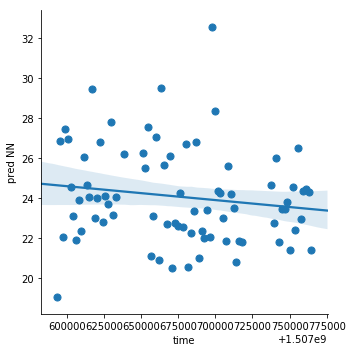

actual mds: 11


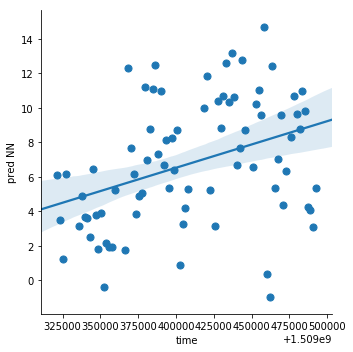

actual mds: 24


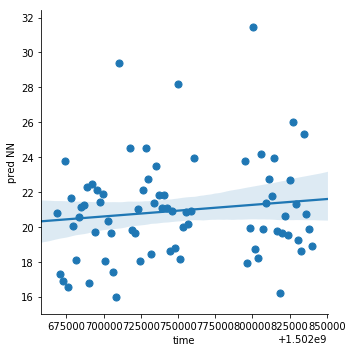

actual mds: 14


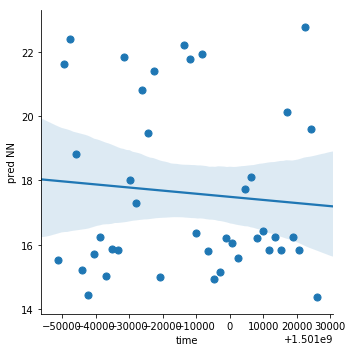

actual mds: 16


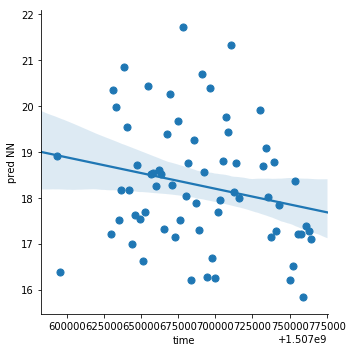

actual mds: 32


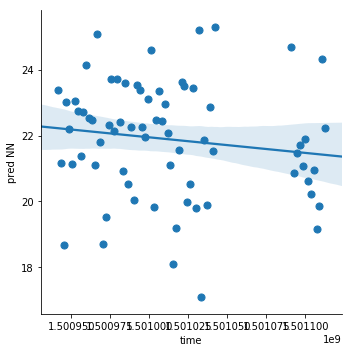

actual mds: 27


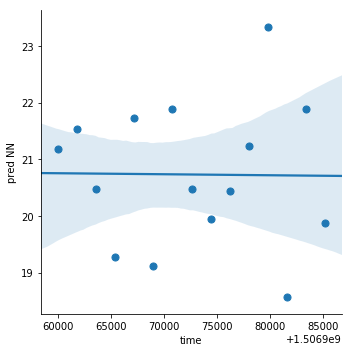

actual mds: 24


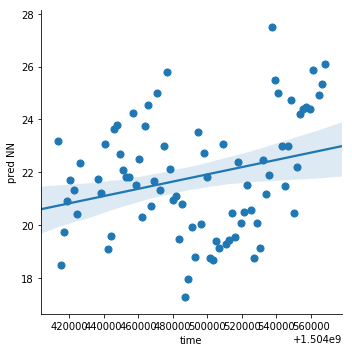

actual mds: 10


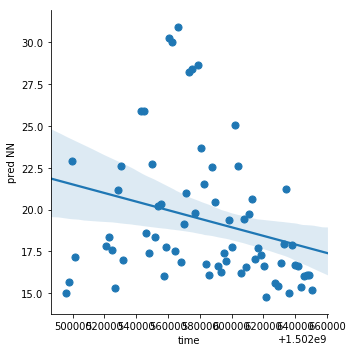

actual mds: 18


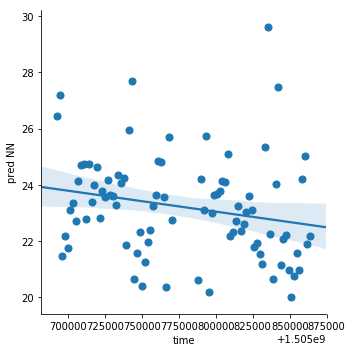

actual mds: 29


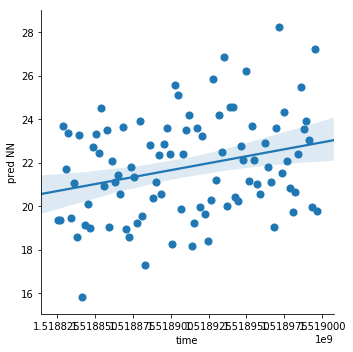

actual mds: 24


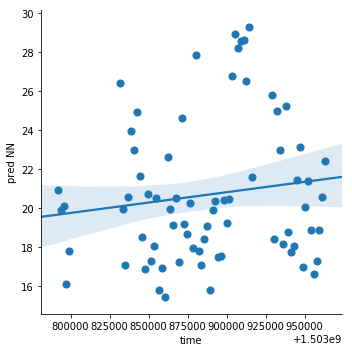

actual mds: 28


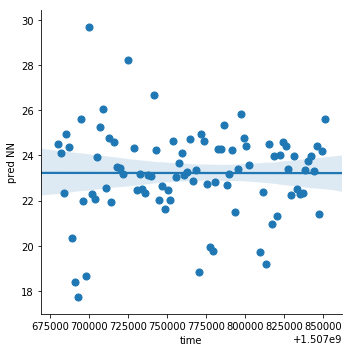

actual mds: 26


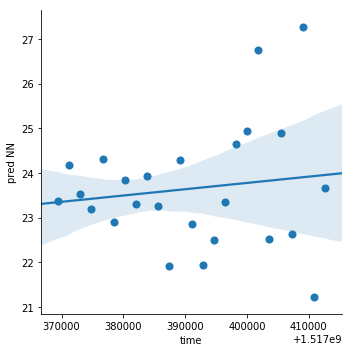

actual mds: 19


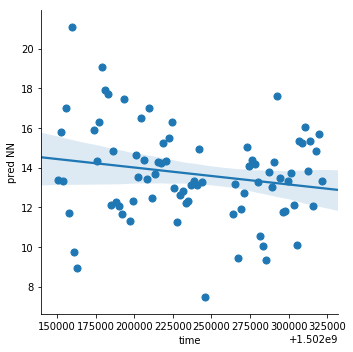

actual mds: 16


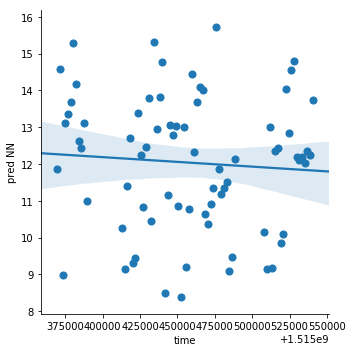

actual mds: 24


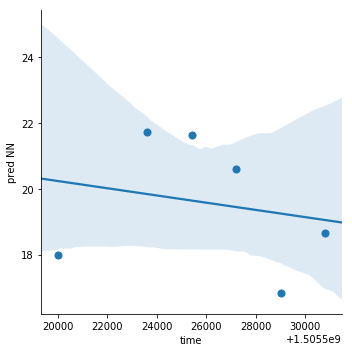

actual mds: 22


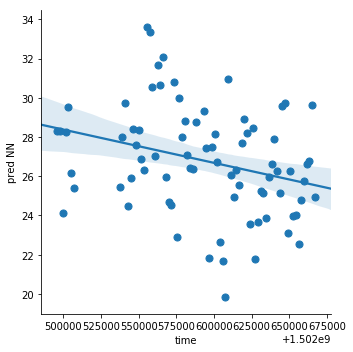

actual mds: 18


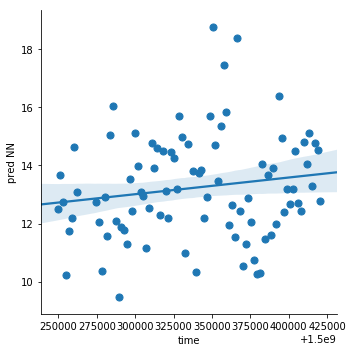

actual mds: 21


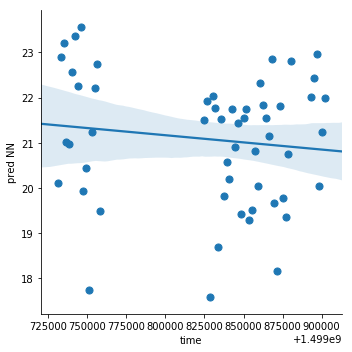

actual mds: 12


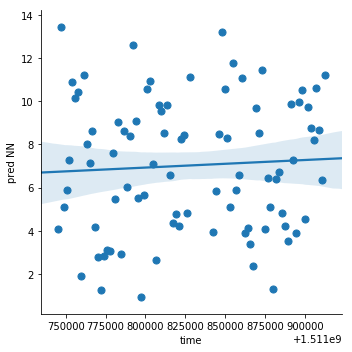

actual mds: 12


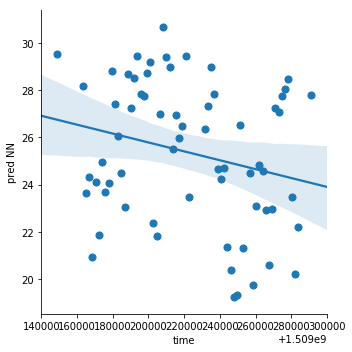

actual mds: 21


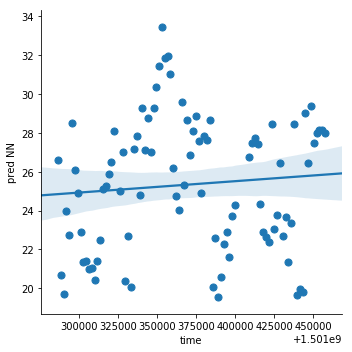

actual mds: 25


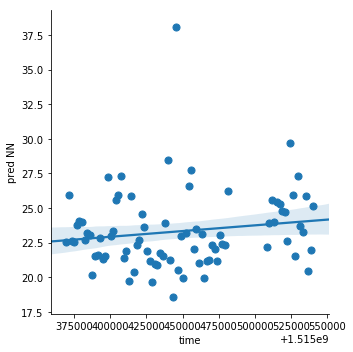

actual mds: 16


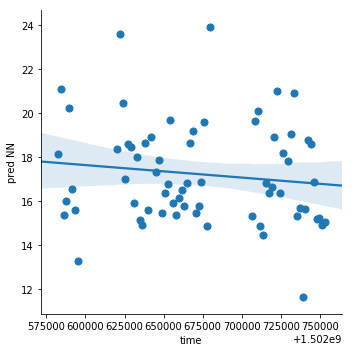

actual mds: 20


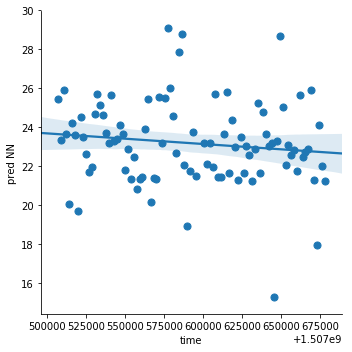

actual mds: 32


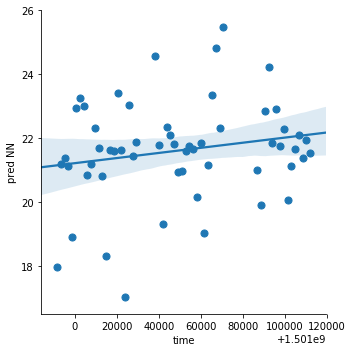

actual mds: 25


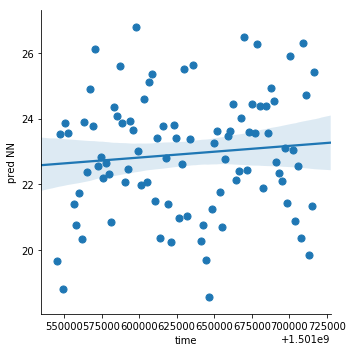

actual mds: 12


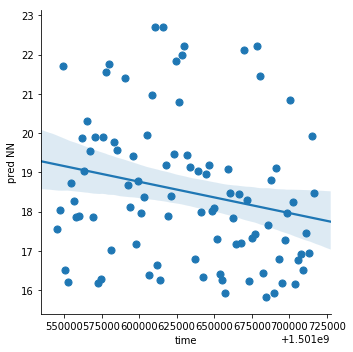

actual mds: 23


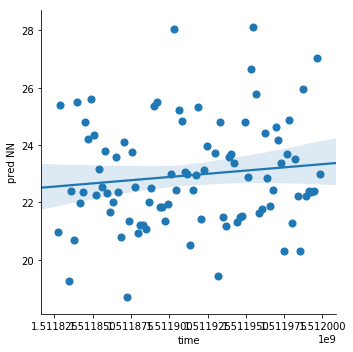

actual mds: 22


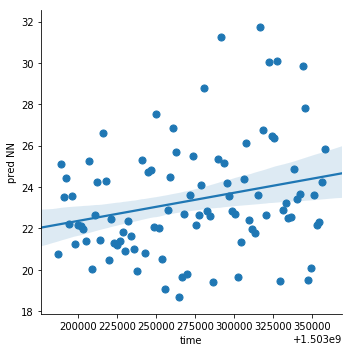

actual mds: 26


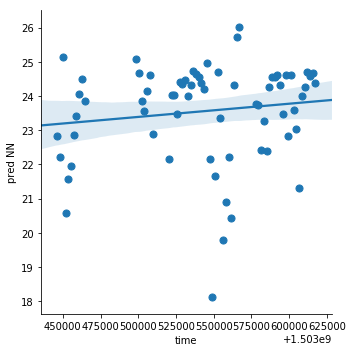

actual mds: 13


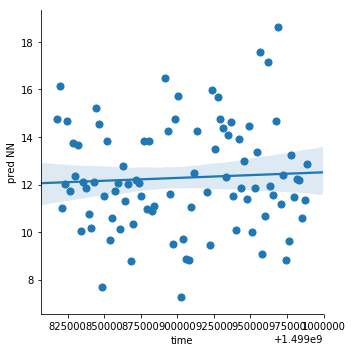

actual mds: 21


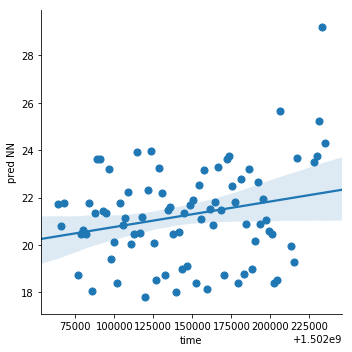

actual mds: 9


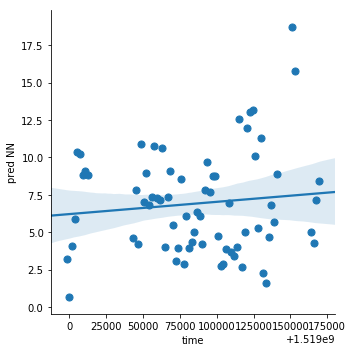

actual mds: 6


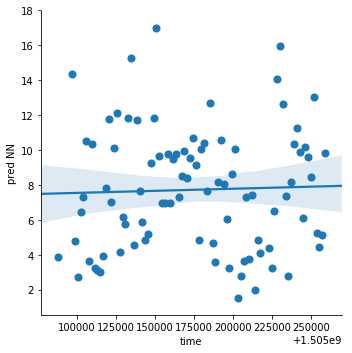

actual mds: 14


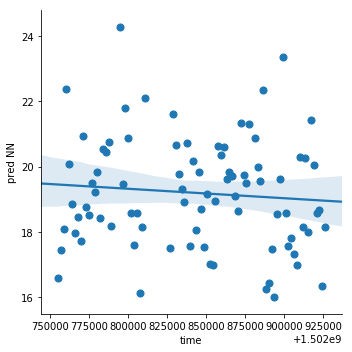

actual mds: 33


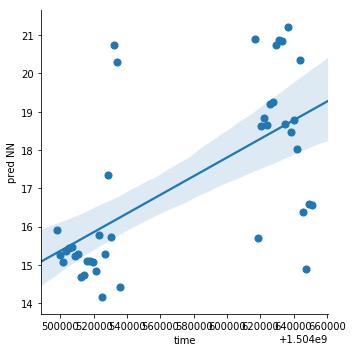

actual mds: 28


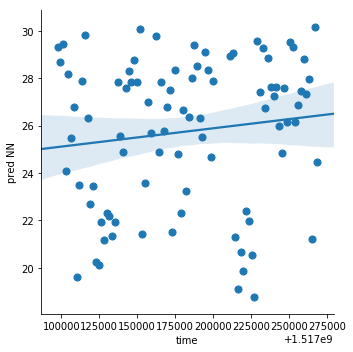

actual mds: 25


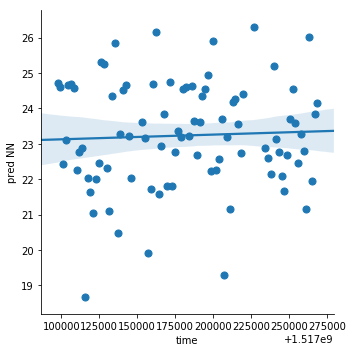

actual mds: 18


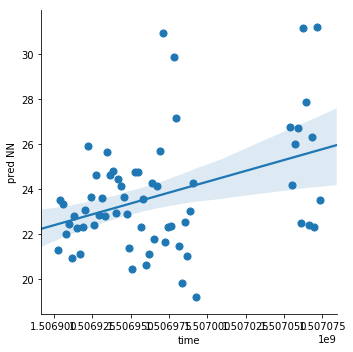

actual mds: 14


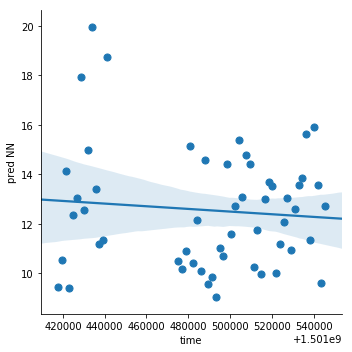

actual mds: 12


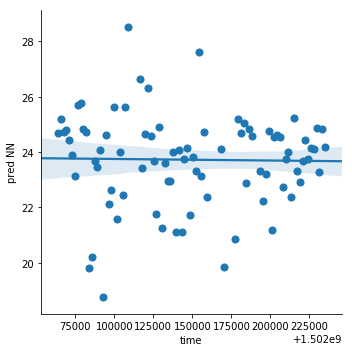

In [15]:
### COMPUTE FINAL PREDICTIONS ###

for c in list(chunks.keys()):

    # create regressors
    clf_stacked_RFR = RandomForestRegressor(n_estimators = 50, random_state = 2)
    clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
    clf_stacked_LN = LinearRegression()
    clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
    clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')
    
    # set up train and test sets
    subj = int(c[9:15])
    stacked_train = newcomplete[newcomplete['subj'] != subj]
    stacked_test = chunks[c]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    actual_mds = stacked_ytest[0]
    time = [((dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')) for dt64 in stacked_test['timestamp'].values]
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 2:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    # scale train and test data
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # train regressors
    #clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    #clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    #clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    #clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions
    #second_stack_predictions_RFR = list(clf_stacked_RFR.predict(stacked_test))
    second_stack_predictions_NN = list(clf_stacked_NN.predict(stacked_test_std))
    #second_stack_predictions_LN = list(clf_stacked_LN.predict(stacked_test_std))
    #second_stack_predictions_LARS = list(clf_stacked_LARS.predict(stacked_test_std))
    #second_stack_predictions_KNR = list(clf_stacked_KNR.predict(stacked_test_std))
    
    # store results
    second_stack_predictions = pd.DataFrame()
    second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'time', value = np.array(time))
    second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(stacked_ytest))
    #second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
    second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
    #second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
    #second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
    #second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
    
    # display results
    sns.lmplot(x = 'time', y = 'pred NN', data = second_stack_predictions, x_estimator = np.mean, order = 1)
    print('actual mds: ' + actual_mds.__str__())
    plt.show()